In [2]:
import scipy.io
import numpy as np
import datetime 
import ephem
import random
from scipy import spatial
import matplotlib.pyplot as plt
%matplotlib
from astropy.table import Table
import astropy.units as u
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
import astropy
from astropy.time import Time
from astropy.coordinates import EarthLocation
data=scipy.io.loadmat('BNS-sources-trial-10saleem.mat')['data'] 
#sourceparameters
DL=data[:,0]
theta=data[:,1]
phi=data[:,2]
print(len(DL),len(theta),len(phi))

Using matplotlib backend: MacOSX
220000 220000 220000


In [3]:
snrH=data[:,5]
snrL=data[:,6]
snrV=data[:,7]
snrK=data[:,8]
snrI=data[:,9]
#or for networks of 5 and 3 detectors, one can use directly,
snrLHVKI=np.sqrt(data[:,5]**2 + data[:,6]**2 + data[:,7]**2 +data[:,8]**2 + data[:,9]**2)  
# SNR at LHVKI
snrLHV=np.sqrt(data[:,5]**2 + data[:,6]**2 + data[:,7]**2 )  # LHV*
snrLHVK = np.sqrt(data[:,5]**2 + data[:,6]**2 + data[:,7]**2 + data[:,8]**2)
snrLHVI = np.sqrt(data[:,5]**2 + data[:,6]**2 + data[:,7]**2 + data[:,9]**2)
len(snrLHVKI),len(snrLHVK)

(220000, 220000)

In [4]:
from astropy.time import Time
#import random

def homotime(number):
    """
    Defines homogenously distributed time over the time 2022-2023. Number of time elements is essentially the number of
    theta,  phi you get.(220000)
    Takes time in UTC format and gives out time in UTC format
    """
    time1 = Time('2022-01-01T00:00:00.123456789')
    time1 = time1.jd
    time2 = Time('2023-01-01T00:00:00.123456789')
    time2 = time2.jd
    dt = (time2-time1)/number
    homotime = []
    
    for i in range(number):
        if i%(int((number)/10))==0:print(int(i*100/(number)), '% completed', end='\r')
        timejd = time1 + i*dt
        timeutc = Time(timejd, format='jd')
        homotime.append(timeutc.iso)
    print('***Completed***', end='\r')
    #print(len(homotime))
    return homotime
homotime = homotime(len(theta))
len(homotime)

220000

In [109]:
t = Time(homotime)
tt=[]
ra = []
dec = []
dist = []
for i in range(0,602):
    tt.append(astropy.coordinates.get_sun(t[i]))   #getting the sun RA ,DEC and Distance in earth's reference frame 
    ra.append(tt[i].ra)                            #in degrees
    dec.append(tt[i].dec)
    dist.append(tt[i].distance)

In [183]:
decnew = []
ranew = []
for i in range(0,602):
    decnew.append(dec[i]/u.deg)
    ranew.append(ra[i]/u.deg)

In [176]:
def ecef_eci(lat, lon, time):  #input in degrees
    """Convert lat long to right ascention and declination
    lat - latitude of the place where the tigger is at the zenith in degrees
    lon - longitude of the place where the tigger is at the zenith in degrees
    time - UTC time in datetime format
    """
    lat = np.deg2rad(lat)
    lon = np.deg2rad(lon)
    temp = time
    year = int(temp[0:4])
    month = int(temp[5:7])
    day = int(temp[8:10])
    hour = int(temp[11:13])
    minu = int(temp[14:16])
    secs = int(temp[17:19])
    #time = Time(time)
    time = datetime.datetime(year, month,day,hour,minu,secs)
    time0 = datetime.datetime(2000, 1, 1, 12, 0, 0)
    time_sid = 18.697374558 + 24.06570982441908*(time - time0).total_seconds()/86400.0
    time_sid = time_sid - 24.0*np.floor(time_sid/24.0)
    dec = lat
    ra = lon + np.pi/24.0*time_sid
    print(ra)
    dec = np.rad2deg(dec)
    ra = np.rad2deg(ra)
    return ra,dec  #output in degrees


def eci_ecef(ra, dec, time):   #input in radians
    """Convert ra dec to lattitude and longitude
    ra - right ascention of the body in radians
    dec - declination of the body in radians
    time - UTC time in datetime format
    """
#     ra = np.deg2rad(ra)
#     dec = np.deg2rad(dec)
    temp = time
    year = int(temp[0:4])
    month = int(temp[5:7])
    day = int(temp[8:10])
    hour = int(temp[11:13])
    minu = int(temp[14:16])
    secs = int(temp[17:19])
    #time = Time(time)
    time = datetime.datetime(year, month,day,hour,minu,secs)
    time0 = datetime.datetime(2000, 1, 1, 12, 0, 0)
    time_sid = 18.697374558 + 24.06570982441908*(time - time0).total_seconds()/86400.0
    time_sid = time_sid - 24.0*np.floor(time_sid/24.0)
    lon = (ra - 2*np.pi/24.0*time_sid)
    lat = dec
#     lon = np.rad2deg(lon)
#     lat = np.rad2deg(lat)
    return lat, lon   #output in radians


def getxyz(theta,phi,n):
    if n==1:
        #lat, long
        theta = np.pi/2 - theta
    x=np.sin(theta)*np.cos(phi)
    y=np.sin(theta)*np.sin(phi)
    z=np.cos(theta)
    return x,y,z
def getnorm(vec):
    norm = np.linalg.norm(vec)
    #print (norm)
    return vec/norm

In [115]:
RAinrad = []    #RA and DEC of sun in radian
DECinrad = []
for i in range(0,602):
    RAinrad.append(np.deg2rad(ra[i]))
    DECinrad.append(np.deg2rad(dec[i]))

In [116]:
latsun = []    #latsun and longsun in radians
longsun = []
for i in range(0,602):
    print(i)
    #q = (eci_ecef((RAinrad[i])/u.rad, (DECinrad[i])/u.rad, homotime[i]))
    latsun.append(eci_ecef((RAinrad[i])/u.rad, (DECinrad[i])/u.rad, homotime[i])[0].value)
    longsun.append(eci_ecef((RAinrad[i])/u.rad, (DECinrad[i])/u.rad, homotime[i])[1].value)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [117]:
line0 = 'ASTROSAT' #Daksha
line1 = '1 40930U 15052A   22302.17850942  .00000772  00000-0  19439-4 0  9990'
line2 = '2 40930   5.9975   0.5159 0009292 339.1937  20.7998 14.76165238112787'
line3 = '2 40930   5.9975   0.5159 0009292 339.1937 200.7998 14.76165238112787'

# line0 = 'SWIFT'#BAT
# line1 = '1 28485U 04047A   22302.18405080  .00001301  00000-0  60140-4 0  9997'
# line2 = '2 28485  20.5572 277.8742 0011565 130.4507 229.6936 15.03911323708409'
# line0 = 'FGRST (GLAST)'#Fermi
# line1 = '1 33053U 08029A   22100.45970249  .00000511  00000-0  12538-4 0  9998'
# line2 = '2 33053  25.5819 140.4060 0012690 120.1881 239.9912 15.11069703542313'
astrosat1 = ephem.readtle(line0,line1,line2)
astrosat2 = ephem.readtle(line0,line1,line3)

sublat1 = []
sublong1 = []
sublat2 = []
sublong2 = []
for i in range(len(homotime)):
    astrosat1.compute(homotime[i])
    astrosat2.compute(homotime[i])
    sublat1.append(astrosat1.sublat)#sublat in radians
    sublong1.append(astrosat1.sublong)#sublong in radian
    sublat2.append(astrosat2.sublat)#sublat in radians
    sublong2.append(astrosat2.sublong)#sublong in radian

In [130]:
satunit = []
sununit = []
for i in range(0,602):
    satunit.append(getxyz(sublat1[i],sublong1[i],1)) #earth to satellite vector
    sununit.append(getxyz(latsun[i],longsun[i],1))  #earth to sun vector

In [220]:
satsun1 = []
satsun2 = []
satsun3 = []
for i in range(0,602):
    satsun1.append([])
    satsun2.append([])
    satsun3.append([])

    satsun1[i] = satunit[i][0]*7000 - sununit[i][0]*1.496*10**8*dist[i]/u.AU
    satsun2[i] = satunit[i][1]*7000 - sununit[i][1]*1.496*10**8*dist[i]/u.AU
    satsun3[i] = satunit[i][2]*7000 - sununit[i][2]*1.496*10**8*dist[i]/u.AU


In [221]:
satunit[1],sununit[1]

((0.7098547132885114, 0.703790611469402, 0.028018944120191094),
 (-0.9202130414168654, 0.0016483482377437542, -0.3914144112758361))

In [204]:
"""sunplussat = []  
   # assuming orbit of DAKSHA to be 7000 km
for i in range(0,602):    #Converting AU to km
    print(i)
    sunplussat.append(sununit[i]*10**8*dist[i] + satunit[i]*7000)
"""

'sunplussat = []  \n   # assuming orbit of DAKSHA to be 7000 km\nfor i in range(0,602):    #Converting AU to km\n    print(i)\n    sunplussat.append(sununit[i]*10**8*dist[i] + satunit[i]*7000)\n'

In [205]:
z = []
thetasunzaxis = []
suntosat1 = [] # 1st component of sun to sat vector
suntosat2 = [] # 2nd component of sun to sat vector
suntosat3 = [] # 3rd component of sun to sat vector
lat = []
a= []
def transformtosun(latsun,longsun):
    for i in range(602):
        satvecold1 = getnorm(getxyz(sublat1[i],sublong1[i],1))
        #suntosat = ((sat[i][0]+sun[i][0])*sun[i][0]+(sat[i][1]+sun[i][1])*sun[i][1]+(sat[i][2]+sun[i][2])*sun[i][2])/(np.linalg.norm(sun[i])*np.linalg.norm(sat[i]))
        sunvecold = (getxyz(latsun[i],longsun[i],1))
        tplus = homotime[i][0:17]+(str(int(homotime[i][17:19])+1)) + homotime[i][19:23]
        #astrosat.compute(tplus)
        #a.append(sun[i]+sat[i])
        sunvecplus = getnorm(getxyz(latsun[i],longsun[i],1))
        z.append(-getnorm(sunvecold))
        zaxis = getnorm(sunvecold)
        xaxistemp = getnorm([sunvecplus[0]-sunvecold[0],sunvecplus[1]-sunvecold[1],sunvecplus[2]-sunvecold[2]])
        yaxis = getnorm(np.cross(zaxis,xaxistemp))
        xaxis = getnorm(np.cross(yaxis,zaxis))
        #np.dot(xaxis,)
        #thetasunzaxis.append(180*np.arccos(np.dot(sat[i]+sun[i],sun[i])/np.pi))
        #lat.append((sunvecold[0]**2 + sunvecold[1]**2 + sunvecold[2]**2)**0.5/((sat[i][0]-sun[i][0])**2+(sat[i][1]-sun[i][1])**2+(sat[i][2]-sun[i][2])**2)**0.5)
        """xtrig,ytrig,ztrig = getxyz(theta[i],phi[i],0)
        trigvec = getnorm([xtrig,ytrig,ztrig])
        thetatrans = np.arccos(np.dot(trigvec,zaxis))
        yprojtrig = np.linalg.norm(trigvec)*np.dot(trigvec,yaxis) #np.dot(trigvec,yaxis) gives the angle cos of angle between trigvec and yaxis
        xprojtrig = np.linalg.norm(trigvec)*np.dot(trigvec,xaxis)
        phitrans = np.arctan2(yprojtrig, xprojtrig)
        thetatransarray.append(thetatrans)
        phitransarray.append(phitrans)"""
    return 

In [206]:
transformtosun(latsun,longsun)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


In [267]:
z[0],satsun1[0],satsun2[0],satsun3[0]

(array([0.92017957, 0.00791785, 0.39141649]),
 <Quantity 1.35373235e+08>,
 <Quantity 1168962.0497459>,
 <Quantity 57581583.30611465>)

In [272]:
(z[0][0]*satsun1[0] + z[0][1]*satsun2[0] + z[0][2]*satsun3[0]),(satsun1[0]**2 + satsun2[0]**2 + satsun3[0]**2)**0.5

(<Quantity 1.47115322e+08>, <Quantity 1.47115322e+08>)

In [207]:
norm = []
for i in range(0,602):
    norm.append((satsun1[i]**2 + satsun2[i]**2 + satsun3[i]**2)**0.5)
    #print((suntosat1[i]*z[i][0]+suntosat2[i]*z[i][1]+suntosat3[i]*z[i][2])/norm[i])

In [260]:
angleinrad = []  # not in degree ,it is in radian
for i in range(0,602):
    angleinrad.append(np.arccos((satsun1[i]*z[i][0]+satsun2[i]*z[i][1]+satsun3[i]*z[i][2])/(norm)))

/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in arccos
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [248]:
angle = []
for i in range(0,602):
    angle.append(90 - (180/np.pi)*angleinrad[i]/u.rad )

In [265]:
norm[14],satsun1[14]*z[14][0]+satsun2[14]*z[14][1]+satsun3[14]*z[14][2]

(<Quantity 1.47116241e+08>, <Quantity 1.47103683e+08>)

In [264]:
angleinrad

[<Quantity [       nan,        nan,        nan,        nan,        nan,
                   nan,        nan,        nan,        nan,        nan,
                   nan,        nan,        nan, 0.00262146, 0.00353451,
            0.00401255, 0.00419577, 0.00411931, 0.0037688 , 0.00306182,
            0.00160894,        nan,        nan,        nan,        nan,
                   nan,        nan,        nan,        nan,        nan,
                   nan,        nan,        nan,        nan,        nan,
                   nan,        nan,        nan,        nan,        nan,
                   nan,        nan,        nan,        nan,        nan,
                   nan,        nan,        nan,        nan,        nan,
                   nan,        nan,        nan,        nan, 0.00258007,
            0.00344369, 0.00387578, 0.00400883, 0.00387012, 0.00343028,
            0.00255167,        nan,        nan,        nan,        nan,
                   nan,        nan,        nan,        nan,     

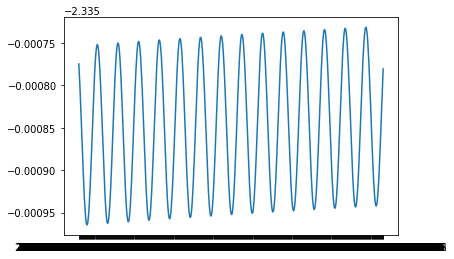

In [211]:
plt.plot(homotime[0:602],angle[0:602])    #for anti-sun orbit

In [159]:
DECsat1[0],sublat1[0]

(0.04314825311303139, 0.04314825311303139)

In [178]:
RAsat1 = []   #RA and DEC of both satellite daksha w.r.t earth in degrees
DECsat1 = []
RAsat2 = []
DECsat2 = []
for i in range(602):
    RAsat1.append(ecef_eci(np.rad2deg(sublat1[i]), np.rad2deg(sublong1[i]), homotime[i])[0])
    #DECsat1.append(ecef_eci((sublat1[i]), (sublong1[i]), homotime[i])[1])
    #RAsat2.append(ecef_eci(np.rad2deg(sublat2[i]), np.rad2deg(sublong2[i]), homotime[i])[0])
    #DECsat2.append(ecef_eci(np.rad2deg(sublat2[i]), np.rad2deg(sublong2[i]), homotime[i])[1])

1.5163815560600395
1.6644850377690938
1.8124103611949143
1.9602720093990986
2.1080773486749864
2.255946226506014
2.40398662903988
2.5521864318510814
2.7006198848774217
2.849341926128939
2.9982705745402636
3.147412965207753
3.2967563252764087
3.4461604995437516
3.5955916151143423
3.745010553868764
3.8942800216389144
4.043382596407503
-2.090862691370058
-1.9421713886504195
-1.7936412743550791
-1.6453135599761892
-1.4970981407404373
-1.3488908452012005
-1.2006933073626906
-1.0523927726980091
-0.9038880499813431
-0.7551963896376452
-0.6062489061585716
-0.45699566831281624
-0.3075248560526145
-0.15783541395156742
-0.007951797386476889
0.14197874550268708
0.29190887115552766
0.44178652725614054
0.591460591358836
0.7408989488899573
0.8900932377420301
1.0389455922080422
1.187497025174325
1.3358095303621713
1.4838618414836857
1.6317554850446176
1.7796062851996435
1.9274250355244151
2.075362500832944
2.2234177027835402
2.371679136801249
2.520218787835944
2.6689719601768593
2.817963312674488
2.96

Text(0,0.5,'Declination in radians')

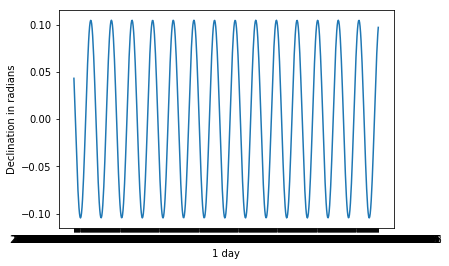

In [174]:
plt.plot(homotime[0:602],DECsat1[0:602])
plt.xlabel("1 day")
plt.ylabel("Declination in radians")#for anti-earth orbit   #in radians

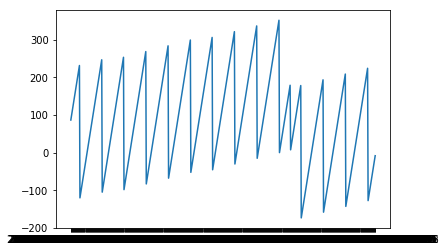

In [179]:
plt.plot(homotime[0:602],RAsat1[0:602]) 

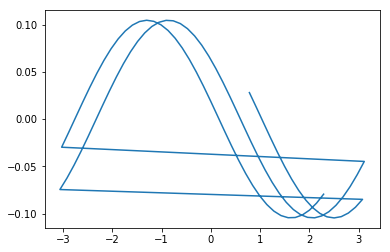

In [173]:
plt.plot(sublong1[1:100],sublat1[1:100])

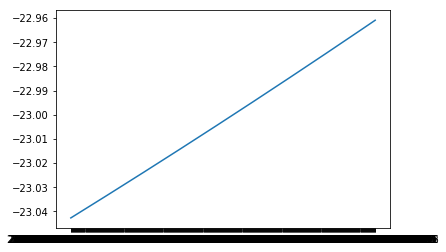

In [182]:
plt.plot(homotime[0:602],decnew[0:602])   #declination of sun w.r.t earth in deg

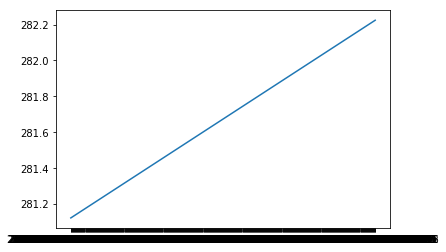

In [185]:
plt.plot(homotime[0:602],ranew[0:602])   #RA of sun w.r.t earth in deg

In [188]:
longsun

[3.1501971251876077,
 3.139801387436661,
 3.1294056494046725,
 3.118936990374716,
 3.108541252226802,
 3.0981455142364833,
 3.0876768548094873,
 3.0772811167184075,
 3.0668853783309746,
 3.056416718953117,
 3.046020980457265,
 3.0356252419033405,
 3.025156582351368,
 3.014760843681362,
 3.004365105168773,
 2.993896445227051,
 2.9835007066058914,
 2.973104967695892,
 2.962636307802973,
 2.9522405687767126,
 2.941771908759887,
 2.9313761696325242,
 2.9209804304317792,
 2.910511770240401,
 2.9001160309308904,
 2.889720291786308,
 2.87925163119716,
 2.8688558919361173,
 2.8584601523936923,
 2.8479914918529365,
 2.8375957521939785,
 2.827200012692252,
 2.816731351761159,
 2.8063356119196605,
 2.7959398722506257,
 2.7854712111445368,
 2.7750754713512022,
 2.7646797312839633,
 2.754211070218344,
 2.7438153300343844,
 2.7334195900151594,
 2.7229509285512234,
 2.71255518841514,
 2.702159447989906,
 2.691690786358261,
 2.681295046039257,
 2.670826384290687,
 2.660430643854729,
 2.650034903144769

In [189]:
RAinrad

[<Angle 4.90652248 rad>,
 <Angle 4.90655447 rad>,
 <Angle 4.90658645 rad>,
 <Angle 4.90661844 rad>,
 <Angle 4.90665043 rad>,
 <Angle 4.90668242 rad>,
 <Angle 4.9067144 rad>,
 <Angle 4.90674639 rad>,
 <Angle 4.90677838 rad>,
 <Angle 4.90681037 rad>,
 <Angle 4.90684235 rad>,
 <Angle 4.90687434 rad>,
 <Angle 4.90690633 rad>,
 <Angle 4.90693831 rad>,
 <Angle 4.9069703 rad>,
 <Angle 4.90700229 rad>,
 <Angle 4.90703428 rad>,
 <Angle 4.90706626 rad>,
 <Angle 4.90709825 rad>,
 <Angle 4.90713024 rad>,
 <Angle 4.90716222 rad>,
 <Angle 4.90719421 rad>,
 <Angle 4.9072262 rad>,
 <Angle 4.90725818 rad>,
 <Angle 4.90729017 rad>,
 <Angle 4.90732216 rad>,
 <Angle 4.90735414 rad>,
 <Angle 4.90738613 rad>,
 <Angle 4.90741811 rad>,
 <Angle 4.9074501 rad>,
 <Angle 4.90748209 rad>,
 <Angle 4.90751407 rad>,
 <Angle 4.90754606 rad>,
 <Angle 4.90757804 rad>,
 <Angle 4.90761003 rad>,
 <Angle 4.90764202 rad>,
 <Angle 4.907674 rad>,
 <Angle 4.90770599 rad>,
 <Angle 4.90773797 rad>,
 <Angle 4.90776996 rad>,
 <Angl